# TD 4

[Use pytorch for all questions]

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import time

## Width vs Depth

Our goad here is to compare the performances of basic networks.
We will create both very wide and very deep networks, and see which ones are better.

We will try to fit a sequence of functions with increasing complexity, both with a wide and with a deep network.
The first part concentrates on the minimal amount of neurons needed to fit the function with an optimal network (setting the weights and biases manually).
Then, the second part studies the training of the same networks, to fit the same functions. 

### Theory

Taking the function of interest: $f: \mathbb{R} \to \mathbb{R}(x)$ to be linear by segment, with 4 segments:
- $f(x) = 0$ on $\left] -\infty, 0 \right]$
- $f(x) = 2x$ on $\left] 0, \frac{1}{2} \right]$
- $f(x) = 2-2x$ on $\left] \frac{1}{2}, 1 \right]$
- $f(x) = 0$ on $\left] 1, \infty \right]$

Define $f(x)$ as a python function, using numpy.

Let also:
- $g(x, 2) = f(x) \circ f(x)$
- $g(x, 3) = f(x) \circ f(x) \circ f(x)$
- $g(x, 4) = f(x) \circ f(x) \circ f(x) \circ f(x)$
- etc...

Define $g(x, l)$ as a python function.

Plot $f$ and $g$ on $\left] -1.2, 1.2 \right]$

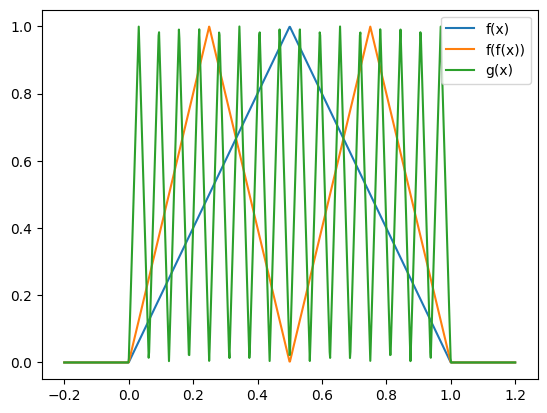

In [2]:
def f(x):
    return 1-(2*np.abs(x-0.5)).clip(0,1)

x = np.linspace(-0.2, 1.2, 1000)
y = f(x)
plt.plot(x, y, label="f(x)")
y = f(f(x))
plt.plot(x, y, label="f(f(x))")
# y = f(f(f(x)))
# plt.plot(x, y, label="f(f(f(x)))")

def g(x, lvl=5):
    for i in range(lvl):
        x = f(x)
    return x

y = g(x)
plt.plot(x, y, label="g(x)")
plt.legend()
plt.show()

Define a basic "rectange" network class (width is the same in all hidden layers);
leave the number of layers and number of neurons per layer as parameters, and use ReLU activation function.
The input and output are 1D, since we fit functions $\mathbb{R} \to \mathbb{r}$.

With 4 hidden layers and 5 neurons per layer, your network class should create a network as follows:

![rectangle network diagram](../images/rectangle_network.svg)

In [6]:
class Net(nn.Module):
    def __init__(self, n_layers=1, n_hidden=3):
        super(Net, self).__init__()
        self.fc_in = nn.Linear(1, n_hidden)
        self.fcs = []
        for i in range(n_layers-1):
            self.fcs.append(nn.Linear(n_hidden, n_hidden))
        self.fc_out = nn.Linear(n_hidden, 1)

    def forward(self, x):
        x = F.relu(self.fc_in(x))
        for i in range(len(self.fcs)):
            x = F.relu(self.fcs[i](x))
        x = self.fc_out(x)
        return x

Implement $f$ with a (basic) rectangle network with 1 hidden layer of 3 neurons.
Set the weights youself to fit exactly the function.

*Hint:*
$f(x) = 2x_+ -4(x-\frac{1}{2})_+ +2(x-1)_+$
$\qquad \qquad$ (where $\alpha_+$ is $ReLU(\alpha)$)

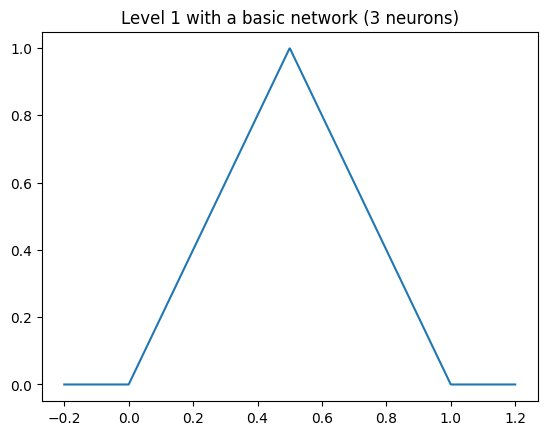

In [7]:
basic = Net(1, 3)
basic.fc_in.weight = torch.nn.Parameter(torch.tensor([[1.0], [1.0], [1.0]]))
basic.fc_in.bias = torch.nn.Parameter(torch.tensor([0.0, -0.5, -1.0]))
basic.fc_out.weight = torch.nn.Parameter(torch.tensor([[2.0, -4.0, 2.0]]))
basic.fc_out.bias = torch.nn.Parameter(torch.tensor([0.0]))

x = np.linspace(-0.2, 1.2, 1000)
y = basic(torch.tensor(x).float().view(-1, 1)).detach().numpy()
plt.plot(x, y, label="basic(x)")
plt.title(f'Level 1 with a basic network (3 neurons)')
plt.show()

Now, implement $g$ for `level = 4`, by increasing the width (and keeping a single hidden layer).
Use again a rectangle network and set the weights youself.

*Hint: try to find the weight for `level = 2`, then `level = 3`, and deduce the pattern.*

Neurons used: 17


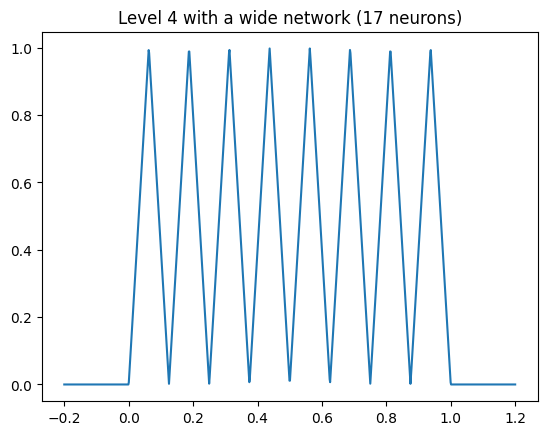

In [14]:
level = 4
d = 1
n = 2**level + 1
print(f'Neurons used: {n*d}')
wide = Net(d, n)

wide.fc_in.weight = torch.nn.Parameter(torch.tensor([[1.0]]*n))
wide.fc_in.bias = torch.nn.Parameter(-torch.arange(0, n)/(n-1))
wide.fc_out.weight = torch.nn.Parameter(torch.tensor([[1.0]+[-2.0, 2.0]*((n-3)//2)+[-2.0, 1.0]])*(n-1))
wide.fc_out.bias = torch.nn.Parameter(torch.tensor([0.0]))

x = np.linspace(-0.2, 1.2, 1000)
y = wide(torch.tensor(x).float().view(-1, 1)).detach().numpy()

plt.plot(x, y)
plt.title(f'Level {level} with a wide network ({n*d} neurons)')
plt.show()

How many neurons did you need in the hidden layer? How will that evolve when the level increase?

We need $2^{level}+1$ neurons, this increases exponentially with `level`.

-----

Now, implement $g$ for `level = 4`, by increasing the depth (and keeping 3 neuron per hidden layer).
Again use a rectangle network and set the weights youself.

*Hint: try to find the weight for `level = 2`, then `level = 3`, and deduce the pattern.*

Neurons used: 12


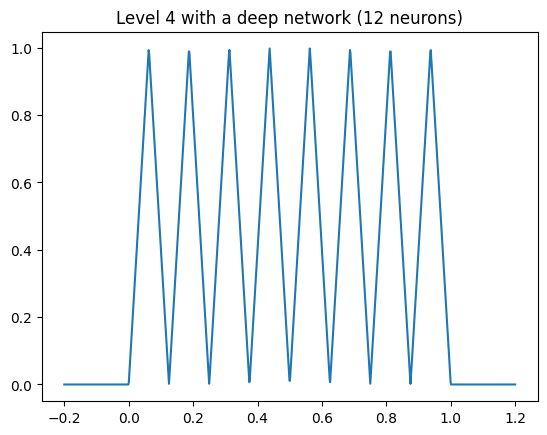

In [22]:
level = 4
d = level
n = 3
print(f'Neurons used: {n*d}')
deep = Net(d, n)

deep.fc_in.weight = torch.nn.Parameter(torch.tensor([[1.0], [1.0], [1.0]]))
deep.fc_in.bias = torch.nn.Parameter(torch.tensor([0.0, -0.5, -1.0]))
for i in range(d-1):
    deep.fcs[i].weight = torch.nn.Parameter(torch.tensor([\
        [ 2., -4.,  2.],
        [ 2., -4.,  2.],
        [ 2., -4.,  2.]
        ]))
    deep.fcs[i].bias = torch.nn.Parameter(torch.tensor([0.0, -0.5, -1.0]))
deep.fc_out.weight = torch.nn.Parameter(torch.tensor([[2.0, -4.0, 2.0]]))
deep.fc_out.bias = torch.nn.Parameter(torch.tensor([0.0]))

x = np.linspace(-0.2, 1.2, 1000)
y = deep(torch.tensor(x).float().view(-1, 1)).detach().numpy()

plt.plot(x, y)
plt.title(f'Level {level} with a deep network ({n*d} neurons)')
plt.show()

How many neurons did you need in the hidden layer? How will that evolve when the level increase?

We need $3*{level}$ neurons, this increases linearly with `level`.

In a semilogy, plot the number of neuron used to replicate $g$ as a function of `level` (ranging from 1 to 15), by increasing the width and the depth.

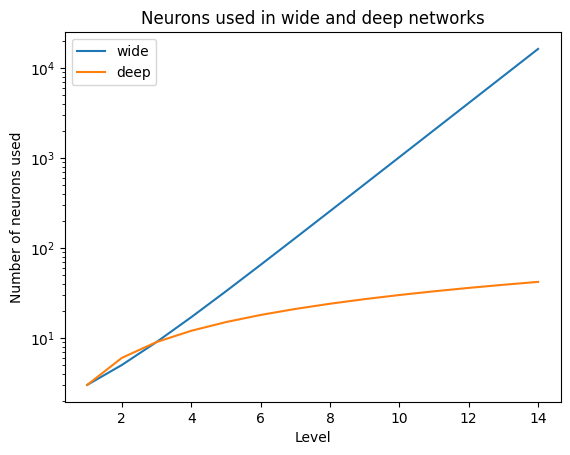

In [25]:
lvls = np.arange(1, 15)
wide = 2**lvls + 1
deep = 3*lvls
plt.semilogy(lvls, wide, label='wide')
plt.semilogy(lvls, deep, label='deep')
plt.legend()
plt.title('Neurons used in wide and deep networks')
plt.xlabel('Level')
plt.ylabel('Number of neurons used')
plt.show()

### Training

We will try to fit `g` with `level = 4` both with deep and wide networks; This time, by training the network, instead of manually setting the weights.

First, train a wide network, of course, it will need more neurons than the mathematically optimal solutions.
Try with 5 times more neurons than in the optimal solution, and about $15000$ epochs.

Neurons used (theory): 68
Neurons used (practice): 340
Loss: 0.22030109167099
Loss: 0.059398144483566284
Loss: 0.053543396294116974
Loss: 0.0500367097556591
Loss: 0.04687894508242607
Loss: 0.043461766093969345
Loss: 0.041120901703834534
Loss: 0.03985315188765526
Loss: 0.03830098733305931
Loss: 0.03790999948978424
Loss: 0.04599668085575104
Loss: 0.030949028208851814
Loss: 0.025638088583946228
Loss: 0.02809027023613453
Loss: 0.041976623237133026


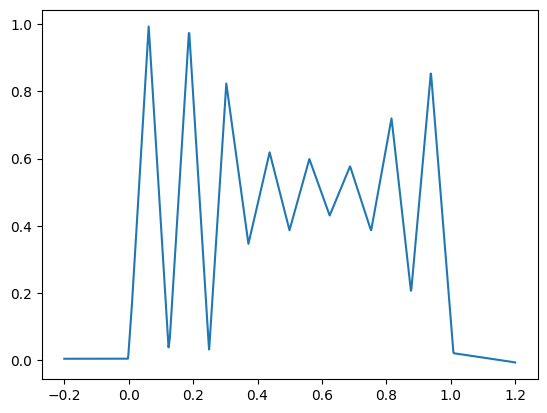

In [26]:
# cretae a wide network for lvl=5 and train it
level = 4
n = 2**level + 1
print(f'Neurons used (theory): {n*level}')
wide = Net(0, n*5)
print(f'Neurons used (practice): {(n*5)*level}')

x = np.linspace(-0.2, 1.2, 1000)
y = g(x, level)

# train the network
optimizer = torch.optim.Adam(wide.parameters(), lr=0.02)
for i in range(15000):
    optimizer.zero_grad()
    pred = wide(torch.tensor(x).float().view(-1, 1))
    loss = F.mse_loss(pred, torch.tensor(y).float().view(-1, 1))
    loss.backward()
    optimizer.step()
    if i % 1000 == 0:
        print(f'Loss: {loss.item()}')

# plot the result
y = wide(torch.tensor(x).float().view(-1, 1)).detach().numpy()
plt.plot(x, y, label="wide(x)")

*Convergence is not reached, but given a little more time, it should converge nicely towards the solution.*

Now, train a deep network, again, give a little slack on the number of neurons compared to the optimal solution.
Try with 10 times more layers than necessart, and 15 neurons per layer instead of 3, and about $5000$ epochs.

Neurons used (theory): 12
Neurons used (practice): 600
Loss: 0.15821489691734314
Loss: 0.11055728048086166
Loss: 0.11055728048086166
Loss: 0.11055728048086166
Loss: 0.11055726557970047


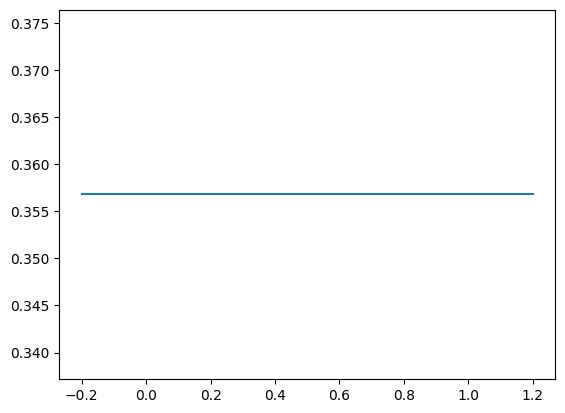

In [27]:
# cretae a deep network and train it
level = 4
print(f'Neurons used (theory): {3*level}')
deep = Net(level*10, 15)
print(f'Neurons used (practice): {15*(level*10)}')

x = np.linspace(-0.2, 1.2, 1000)
y = g(x, level)

# train the network
optimizer = torch.optim.Adam(deep.parameters(), lr=0.02)
for i in range(5000):
    optimizer.zero_grad()
    pred = deep(torch.tensor(x).float().view(-1, 1))
    loss = F.mse_loss(pred, torch.tensor(y).float().view(-1, 1))
    loss.backward()
    optimizer.step()
    if i % 1000 == 0:
        print(f'Loss: {loss.item()}')

# plot the result
y = deep(torch.tensor(x).float().view(-1, 1)).detach().numpy()
plt.plot(x, y, label="deep(x)")

- *See that the training takes much more time than with the wide network, despite the fact that we have less epochs.*
- *Observe also that there is no sign of convergence; Try to explain this.*

**Conclusion:**

The number of neurons is a good measure of the size (in terms of memory) of your network;
For the same amount of neurons, deep networks, can catch more complexity, but are harder to train.
On the contrary, wide networks catch less complexity, but are easier to train.

*Your goal as an AI engineer is to find the best architectures, so that your networks are both trainable and able to catch the complexity of the observed phenomenon.*

## RNN

### Determinating Lastnames Origins... with RNN

The goal here is to build our first (basic) RNN network.

We have a datset composed of 18000 names, from 18 nationalities (1000 names from each country).
We try to build a network to classify names to their correct nationality.
We do that with a RNN, that "reads" each letter one by one.

Link to the dataset *name_1000*, containing 1000 names from 18 nationalities:
https://drive.google.com/drive/folders/1qqyB_ZRMsz_7veqlKYnJH2kmYK6myV4Y?usp=share_link

Start by downloading it and store it in your working directory.

In [1]:
import unidecode import unidecode
import glob
import os
import torch
import torch.nn as nn
import torch.optim as optim

#### Pre-processing
Some countries are using non-latin alphabet, we need the ASCII version.
You can try the function `unidecode` from the `unidecode` mdule.

Create a function that takes a name, and return its version using only letters from 
`LETTERS = 'abcdefghijklmnopqrstuvwxyzABCDEFGHIJKLMNOPQRSTUVWXYZ .,;'` (you can add some letters if you want, but the more you add, the more complex your network will become).

In [24]:
unidecode('Ślusàrski'), unidecode('François'), unidecode('北亰'), unidecode('Kožušček'), unidecode('+-*/')

('Slusarski', 'Francois', 'Bei Jing ', 'Kozuscek', '+-*/')

In [23]:
LETTERS = 'abcdefghijklmnopqrstuvwxyzABCDEFGHIJKLMNOPQRSTUVWXYZ .,;'
N_LETTERS = len(LETTERS)

def unicodeToAscii(s):
    return ''.join(c for c in unidecode(s) if c in LETTERS)

unicodeToAscii('Ślusàrski'), unicodeToAscii('François'), unicodeToAscii('北亰'), unicodeToAscii('kožušček'), unicodeToAscii('+-*/')

('Slusarski', 'Francois', 'Bei Jing ', 'kozuscek', '')

#### Feeding letters to a network
A network can not, originally, process characters/letters; networks can only understand numbers, and list of numbers.
We need to turn our characters to a vector. We could just take the binary byte representing the character in the ASCII. However, this would be very hard for the network to understand (`x: 1011000`,s `y:1011001` and `z: 1011010` will have very similar activations).
Thus, we will use 'one-hot encoding' of our set of letters `LETTERS`. That is, we transform each letter to a tensor of size `<1xN_LETTERS>`, where all entries are zero except the one corresponding to the position of the letter, that we set to one.
e.g.:
- `a => [1, 0, 0, 0, ..., 0]`
- `b => [0, 1, 0, 0, ..., 0]`
- `c => [0, 0, 1, 0, ..., 0]`

Define a `letterToTensor` function that perfoms this operation.

In [25]:
# Turn a letter into a <1 x n_letters> tensor
def letterToTensor(letter):
    tensor = torch.zeros(1, N_LETTERS)
    tensor[0][LETTERS.find(letter)] = 1
    return tensor

letterToTensor('a'), letterToTensor('b'), letterToTensor('c')

(tensor([[1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0.]]),
 tensor([[0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0.]]),
 tensor([[0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0.]]))

Now define a `nameToTensor` function that perfoms this operation for each letter in the name (resulting to a `<name_length x 1 x N_LETTERS>` tensor).

In [26]:
# Turn a name into a <name_length x 1 x N_LETTERS> tensor
def nameToTensor(name):
    tensor = torch.zeros(len(name), 1, N_LETTERS)
    for li, letter in enumerate(name):
        tensor[li][0][LETTERS.find(letter)] = 1
    return tensor

nameToTensor('abc'), nameToTensor('abc').shape

(tensor([[[1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
           0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
           0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
           0., 0., 0., 0., 0.]],
 
         [[0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
           0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
           0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
           0., 0., 0., 0., 0.]],
 
         [[0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
           0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
           0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
           0., 0., 0., 0., 0.]]]),
 torch.Size([3, 1, 56]))

Create a custom dataset:
- in the `__init__`, read all files, and create a list of names and associated country
- add a `countryID` method that turns a country its index
- add a `countryTensor` method that turns a country to a one-hot encoded tensor
- the `__getitem__` should return one piece of data in the form `(name, country, nameTensor, countryID)`

In [33]:
from torch.utils.data import Dataset

class NamesDataset(Dataset):
    def __init__(self, filenames='names/*.txt'):
        #read data
        self.names = []
        self.countries = []
        self.country_to_idx = {}
        self.idx_to_country = []
        for filename in glob.glob(filenames):
            country = os.path.splitext(os.path.basename(filename))[0]
            self.country_to_idx[country] = len(self.country_to_idx)
            self.idx_to_country.append(country)
            lines = open(filename, encoding='utf-8').read().strip().split('\n')
            for line in lines:
                self.names.append(unicodeToAscii(line))
                self.countries.append(country)
        self.n = len(self.names)
        self.n_countries = len(self.country_to_idx)
        print(f'Loaded {self.n} names from {self.n_countries} countries')
    
    def countryTensor(self, index):
        tensor = torch.zeros(1, self.n_countries)
        tensor[0][self.country_to_idx[self.countries[index]]] = 1
        return tensor

    def countryID(self, index):
        return torch.tensor(self.country_to_idx[self.countries[index]])

    def __getitem__(self, index):
        return (self.names[index], self.countries[index], \
            nameToTensor(self.names[index]), self.countryID(index))
    
    def __len__(self):
        return self.n

dataset = NamesDataset('data/names_1000/*.txt')

dataset[0][0], dataset[0][1], dataset[0][2].shape, dataset[0][3]

Loaded 18000 names from 18 countries


('Handal', 'Arabic', torch.Size([6, 1, 56]), tensor(0))

Split data into train and test with `torch.utils.data.dataset.random_split` (80% for training; 20% for testing)

In [35]:
from torch.utils.data.dataset import random_split

train_fraction = 0.8
train_size = int(train_fraction*len(dataset))
test_size = len(dataset)-int(train_fraction*len(dataset))
train_dataset, test_dataset = random_split(dataset, [train_size, test_size])
N_COUNTRIES = dataset.n_countries

print(f'Train size: {len(train_dataset)}')
print(f'Test size: {len(test_dataset)}')
train_dataset[0][0], train_dataset[0][1], train_dataset[0][2].shape, train_dataset[0][3]

Train size: 14400
Test size: 3600


('Klimes', 'Czech', torch.Size([6, 1, 56]), tensor(2))

Create a dataloader for the training and testing datasets; the `batch_size` must be 1, since different names can have different lengths (and therefore, different tensor size).

In [37]:
from torch.utils.data import DataLoader

train_loader = DataLoader(train_dataset, batch_size=1, shuffle=True) # batch_size 1 as names have different lengths
test_loader = DataLoader(test_dataset, batch_size=1, shuffle=True)

train_loader.dataset[0][0], train_loader.dataset[0][1],\
train_loader.dataset[0][2].shape, train_loader.dataset[0][3]

('Klimes', 'Czech', torch.Size([6, 1, 56]), tensor(2))

This RNN exercise was inspired from the following notebook of the official PyTorch documentation:
https://pytorch.org/tutorials/intermediate/char_rnn_classification_tutorial.html